<a href="https://colab.research.google.com/github/Munniz1309/prev_bitcoin_RNN/blob/main/prev_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import yfinance as yf

In [17]:
# Carregar os dados históricos do Bitcoin
data = yf.download('BTC-USD', start='2015-01-01', end='2024-12-31')
data = data[['Close']]  # Usando apenas o preço de fechamento

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para criar os dados de treinamento
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Criar os dados de treinamento e teste
time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Dividir em dados de treino e teste (80% para treino, 20% para teste)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape para o formato esperado pela LSTM: (samples, time_step, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

[*********************100%***********************]  1 of 1 completed


In [18]:
# Criar o modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dense(units=1)  # Camada de saída com um único valor (preço do Bitcoin)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Prever e reverter a normalização
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Reverter a normalização dos dados reais
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0066 - val_loss: 9.9586e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.6407e-04 - val_loss: 9.4892e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 2.9886e-04 - val_loss: 6.9412e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 2.8302e-04 - val_loss: 6.2419e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 2.6863e-04 - val_loss: 6.5119e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 3.1472e-04 - val_loss: 6.5869e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 3.0618e-04 - val_loss: 4.8211e-04
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 2.2193e-04 - val_loss: 4.7104e-04
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 1.8491e-04 - val_loss: 0.0011
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 2.0910e-04 - val_loss: 3.8262e-04
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [19]:
# Calcular o R² e o MSE
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Exibir os resultados das métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'R²: {r2}')

Mean Squared Error (MSE): 3736433.6642433614
R²: 0.9903914338159112


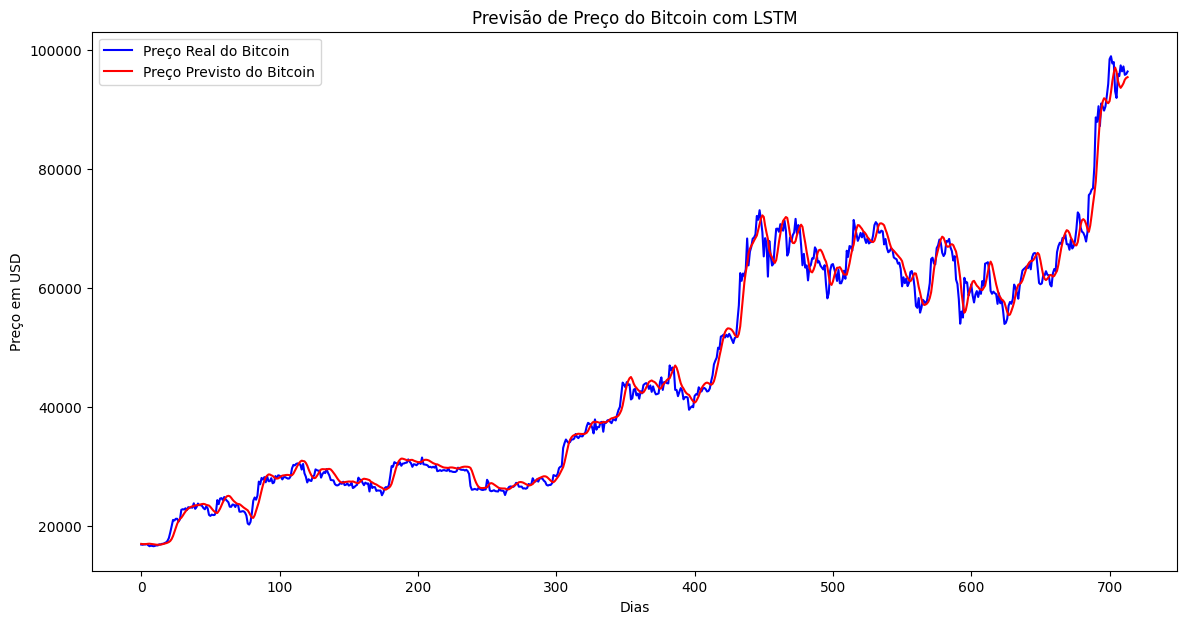

In [20]:
# Visualizar os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Preço Real do Bitcoin')
plt.plot(predictions, color='red', label='Preço Previsto do Bitcoin')
plt.title('Previsão de Preço do Bitcoin com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

In [21]:
# Função para prever os próximos n dias
def predict_future(model, scaled_data, time_step, scaler, future_days):
    input_data = scaled_data[-time_step:]  # Pegar os últimos 'time_step' dias como base
    future_predictions = []

    for _ in range(future_days):
        # Preparar dados de entrada no formato esperado pela LSTM
        input_reshaped = input_data.reshape(1, time_step, 1)

        # Previsão para o próximo dia
        next_prediction = model.predict(input_reshaped)

        # Adicionar a previsão à lista
        future_predictions.append(next_prediction[0, 0])

        # Atualizar os dados de entrada
        input_data = np.append(input_data, next_prediction)[-time_step:]

    # Reverter a escala das previsões para valores reais
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

# Prever os próximos 100 dias
future_days = 100
future_predictions = predict_future(model, scaled_data, time_step, scaler, future_days)

# Criar eixo de tempo para visualização
historical_dates = range(len(data))  # Índices para os dados históricos
future_dates = range(len(data), len(data) + future_days)  # Índices para previsões futuras

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

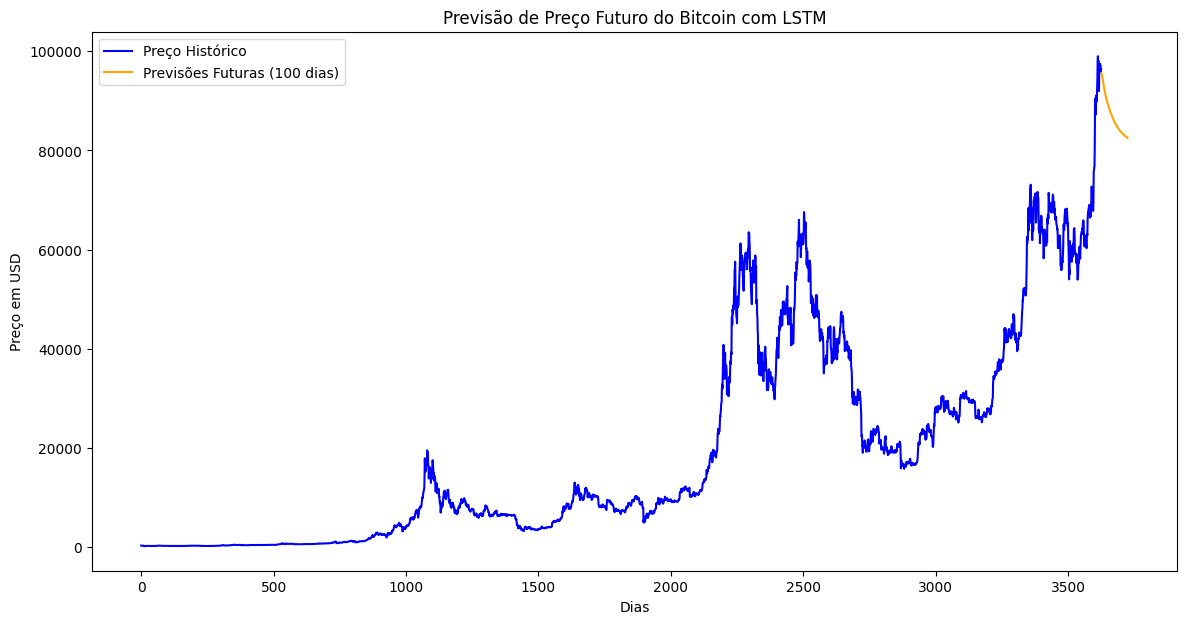

In [22]:
# Visualizar resultados
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, data['Close'], label='Preço Histórico', color='blue')
plt.plot(future_dates, future_predictions, label='Previsões Futuras (100 dias)', color='orange')
plt.title('Previsão de Preço Futuro do Bitcoin com LSTM')
plt.xlabel('Dias')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()